<a href="https://colab.research.google.com/github/Gabendi/DL_HW/blob/master/DL_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.optimizers import SGD,Adam,Adagrad
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [0]:
#loading the data
df = pd.read_csv('/content/sample_data/budapest.csv', sep=',', usecols=["date_time", "maxtempC","mintempC","humidity", "precipMM"])

In [3]:
df.tail()

,date_time,maxtempC,mintempC,humidity,precipMM
4032,2019-10-25,24,17,51,0.0
4033,2019-10-26,24,16,59,0.0
4034,2019-10-27,24,16,57,0.0
4035,2019-10-28,18,13,62,0.2
4036,2019-10-29,11,0,66,6.6


In [0]:
#converting date_time into month+day features
df.insert(loc=0,column="day",value=df['mintempC'])
df.insert(loc=0,column="month",value=df['mintempC'])

def getDays(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((dates[i].split(sep='-')[2]))

    return temp


def getMonths(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((dates[i].split(sep='-')[1]))

    return temp

dates = copy.copy(df["date_time"]) #converting date time

dates = dates.values

df.day = getDays(dates)
df.month=getMonths(dates)

In [0]:
del df['date_time']

In [6]:
Y = copy.copy((df.maxtempC+df.mintempC)/2) #creating the expected target
df.tail()

,month,day,maxtempC,mintempC,humidity,precipMM
4032,10,25,24,17,51,0.0
4033,10,26,24,16,59,0.0
4034,10,27,24,16,57,0.0
4035,10,28,18,13,62,0.2
4036,10,29,11,0,66,6.6


In [0]:
todayData = copy.copy(df.values[-1:len(df)]) #using today's data to predict the upcoming day/week/month

In [0]:
np.random.seed(123) #"deterministic"

Xd = copy.copy(df.values[0:-1]) #data for day prediction
Yd = copy.copy(Y[1:])

randpermd = np.random.permutation(len(Xd)) #permutating


Xd = np.array(Xd,dtype='float')[randpermd.astype(int)]
Yd = np.array(Yd,dtype='float')[randpermd.astype(int)]

Xw = copy.copy(df.values[0:-7]) #data for week prediction
Yw = copy.copy(Y[7:])

randpermw = np.random.permutation(len(Xw))

Xw = np.array(Xw,dtype='float')[randpermw.astype(int)]
Yw = np.array(Yw,dtype='float')[randpermw.astype(int)]

Xm = copy.copy(df.values[0:-28]) #data for month prediction
Ym = copy.copy(Y[28:])


randpermm =np.random.permutation(len(Xm))

Xm = np.array(Xm,dtype='float')[randpermm.astype(int)]
Ym = np.array(Ym,dtype='float')[randpermm.astype(int)]

In [0]:
nb_samplesd = len(Yd)
nb_samplesw = len(Yw)
nb_samplesm = len(Ym)

test_split=0.02 #not sure if any use of test split this time 


#day
X_traind = Xd[0:int(nb_samplesd*(1-test_split))]
Y_traind = Yd[0:int(nb_samplesd*(1-test_split))]
X_testd  = Xd[int(nb_samplesd*(1-test_split)):]
Y_testd  = Yd[int(nb_samplesd*(1-test_split)):]

# #week

X_trainw = Xw[0:int(nb_samplesw*(1-test_split))]
Y_trainw = Yw[0:int(nb_samplesw*(1-test_split))]
X_testw  = Xw[int(nb_samplesw*(1-test_split)):]
Y_testw  = Yw[int(nb_samplesw*(1-test_split)):]

#month
X_trainm = Xm[0:int(nb_samplesm*(1-test_split))]
Y_trainm = Ym[0:int(nb_samplesm*(1-test_split))]
X_testm  = Xm[int(nb_samplesm*(1-test_split)):]
Y_testm  = Ym[int(nb_samplesm*(1-test_split)):]



In [0]:
#standardization
#day
scalerd = preprocessing.StandardScaler().fit(X_traind)
X_traind = scalerd.transform(X_traind)
X_testd  = scalerd.transform(X_testd)
todayd = copy.copy(scalerd.transform(todayData))
#week
scalerw = preprocessing.StandardScaler().fit(X_trainw)
X_trainw = scalerw.transform(X_trainw)
X_testw  = scalerw.transform(X_testw)
todayw = copy.copy(scalerw.transform(todayData))
#month
scalerm = preprocessing.StandardScaler().fit(X_trainm)
X_trainm = scalerm.transform(X_trainm)
X_testm  = scalerm.transform(X_testm)
todaym = copy.copy(scalerm.transform(todayData))


In [0]:
#early stopping
patience=20
early_stoppingd = EarlyStopping(patience=patience, verbose=1)
checkpointerd = ModelCheckpoint(filepath='weightsd.hdf5', save_best_only=True, verbose=1)

early_stoppingw = EarlyStopping(patience=patience, verbose=1)
checkpointerw = ModelCheckpoint(filepath='weightsw.hdf5', save_best_only=True, verbose=1)

early_stoppingm = EarlyStopping(patience=patience, verbose=1)
checkpointerm = ModelCheckpoint(filepath='weightsm.hdf5', save_best_only=True, verbose=1)

In [12]:
#defining the model and training for NEXT DAY
modeld = Sequential()
modeld.add(Dense(128, activation='relu', input_dim=(len(X_traind[0]))))
modeld.add(Dense(64, activation='relu'))
modeld.add(Dense(64, activation='relu'))
modeld.add(Dropout(0.1))
modeld.add(Dense(64, activation='relu'))
modeld.add(Dense(1))

modeld.compile(loss='MSE',
              optimizer='adam')

historyd = modeld.fit(X_traind,Y_traind,
          epochs=1000,batch_size=128,validation_split=0.2,
          callbacks=[checkpointerd, early_stoppingd])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 3164 samples, validate on 791 samples
Epoch 1/100





3164/3164 [==============================] - 1s 387us/step - loss: 180.2410 - val_loss: 101.9454

Epoch 00001: val_loss improved from inf to 101.94540, saving model to weightsd.hdf5
Epoch 2/100
3164/3164 [==============================] - 0s 45us/step - loss: 44.2853 - val_loss: 18.5345

Epoch 00002: val_loss improved from 101.94540 to 18.53445, saving model to weightsd.hdf5
Epoch 3/100
3164/3164 [==============================] - 0s 46us/step - loss: 15.5459 - val_loss: 11.4019

Epoch 00003: val_loss improved from 18.53445 to 11.40194, saving model to weightsd.hdf5
Epoch 4/100
3164/3164 [==============================] - 0s 48us/step - loss: 10.3610 - val_loss: 9.2848

Epoch 00004: val_loss improved from 11.40194 to 9.28477, saving model to weightsd.hdf5
Epoch 5/100
3164/3164 [========================

In [13]:
#Defining model and training for NEXT WEEK

modelw = Sequential()
modelw.add(Dense(128, activation='sigmoid', input_dim=(len(X_trainw[0]))))
modelw.add(Dense(64, activation='relu'))
modelw.add(Dense(64, activation='relu'))
modelw.add(Dense(64, activation='relu'))
modelw.add(Dense(1))

modelw.compile(loss='MSE',
              optimizer='adam')

historyw = modelw.fit(X_trainw,Y_trainw,
          epochs=1000,batch_size=128,validation_split=0.2,
          callbacks=[checkpointerw, early_stoppingw])

Train on 3159 samples, validate on 790 samples
Epoch 1/1000
3159/3159 [==============================] - 1s 168us/step - loss: 154.2978 - val_loss: 71.6487

Epoch 00001: val_loss improved from inf to 71.64870, saving model to weightsw.hdf5
Epoch 2/1000
3159/3159 [==============================] - 0s 48us/step - loss: 72.3721 - val_loss: 60.5605

Epoch 00002: val_loss improved from 71.64870 to 60.56052, saving model to weightsw.hdf5
Epoch 3/1000
3159/3159 [==============================] - 0s 45us/step - loss: 60.9247 - val_loss: 50.1562

Epoch 00003: val_loss improved from 60.56052 to 50.15623, saving model to weightsw.hdf5
Epoch 4/1000
3159/3159 [==============================] - 0s 44us/step - loss: 49.1484 - val_loss: 37.2367

Epoch 00004: val_loss improved from 50.15623 to 37.23670, saving model to weightsw.hdf5
Epoch 5/1000
3159/3159 [==============================] - 0s 43us/step - loss: 32.2748 - val_loss: 20.9729

Epoch 00005: val_loss improved from 37.23670 to 20.97292, saving

In [14]:
#defining and training model for next month
modelm = Sequential()
modelm.add(Dense(64, activation='sigmoid', input_dim=(len(X_trainm[0]))))
modelm.add(Dense(64, activation='relu'))
modelm.add(Dense(64, activation='relu'))
modelm.add(Dense(64, activation='relu'))
modelm.add(Dense(1))

modelm.compile(loss='MSE',
              optimizer='adam')

historym = modelm.fit(X_trainm,Y_trainm,
          epochs=1000,batch_size=128,validation_split=0.2,
          callbacks=[checkpointerm, early_stoppingm])


Train on 3142 samples, validate on 786 samples
Epoch 1/1000
3142/3142 [==============================] - 1s 209us/step - loss: 174.2297 - val_loss: 96.6575

Epoch 00001: val_loss improved from inf to 96.65750, saving model to weightsm.hdf5
Epoch 2/1000
3142/3142 [==============================] - 0s 46us/step - loss: 79.2868 - val_loss: 70.4371

Epoch 00002: val_loss improved from 96.65750 to 70.43705, saving model to weightsm.hdf5
Epoch 3/1000
3142/3142 [==============================] - 0s 46us/step - loss: 65.0330 - val_loss: 58.9687

Epoch 00003: val_loss improved from 70.43705 to 58.96871, saving model to weightsm.hdf5
Epoch 4/1000
3142/3142 [==============================] - 0s 46us/step - loss: 52.6389 - val_loss: 45.3362

Epoch 00004: val_loss improved from 58.96871 to 45.33618, saving model to weightsm.hdf5
Epoch 5/1000
3142/3142 [==============================] - 0s 43us/step - loss: 37.8260 - val_loss: 33.7336

Epoch 00005: val_loss improved from 45.33618 to 33.73363, saving

In [0]:
#RUN THIS CELL TO LOAD MODEL
modeld = load_model('/content/weightsd.hdf5')

modelw = load_model('/content/weightsw.hdf5')

modelm = load_model('/content/weightsm.hdf5')

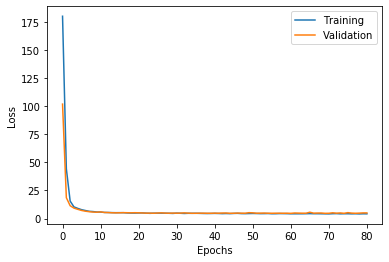

In [16]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

plot_history(historyd)

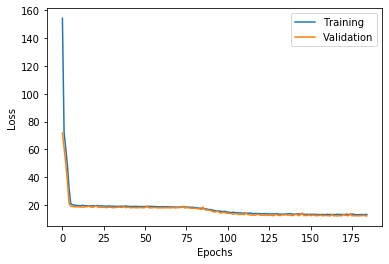

In [17]:
plot_history(historyw)

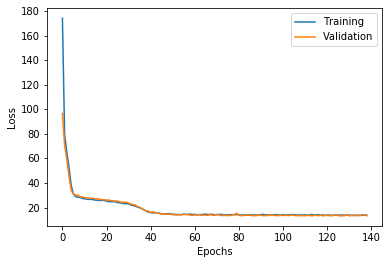

In [18]:
plot_history(historym)

In [19]:
predd = modeld.predict(todayd)
print(predd)

predw = modelw.predict(todayw)
print(predw)

predm = modelm.predict(todaym)
print(predm)

[[3.7926354]]
[[7.7215395]]
[[5.01442]]
